# Эффективность регистрации и рад.поправки

Необходимо определить эффективность регистрации от энергии рад.фотона и с её помощью вычислить рад.поправки

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import pylib.regeff as pyreg
import iminuit
from glob import glob

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
# plt.style.use('./pylib/cmd1202.mplstyle')

In [4]:
SEASON = '19'
FIT_RANGE = (-40, 20)

In [78]:
mc_tree = uproot.open(f'../trees/{SEASON}/uniform.root')['t']

In [79]:
df_mc = preprocess.read_tree(mc_tree, mc=True, align_cut=0.8, z_cut=12)

In [80]:
df_mc = df_mc.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}')

In [81]:
several_points = df_mc.groupby('ebeam').agg({'runnum' : 'nunique'}).query('runnum>1')
several_points

,runnum
ebeam,


**Удаляю одинаковые точки, не из-за того, что плохие, а из-за неумения нормально с ними работать пока**

In [82]:
# df_mc['tz[0]'].hist()

In [83]:
df_mc = df_mc.drop(several_points.index, axis=0)

In [84]:
reg = pyreg.RegEff(df_mc, f'/spoolA/petrov/refac20/data/{SEASON}/trees_uniform.txt')

100% (5 of 5) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


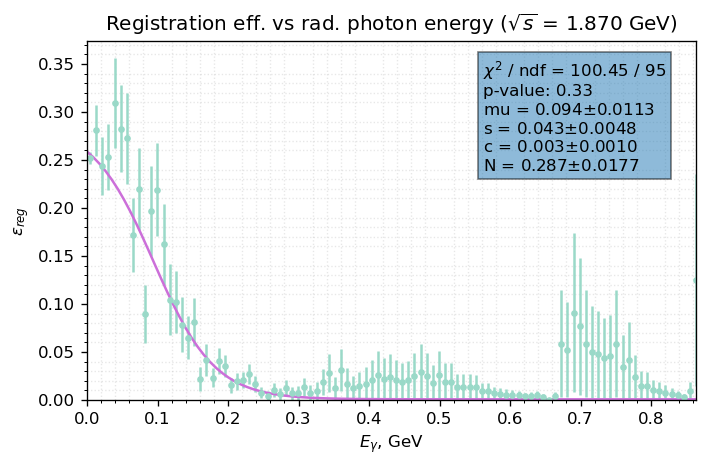

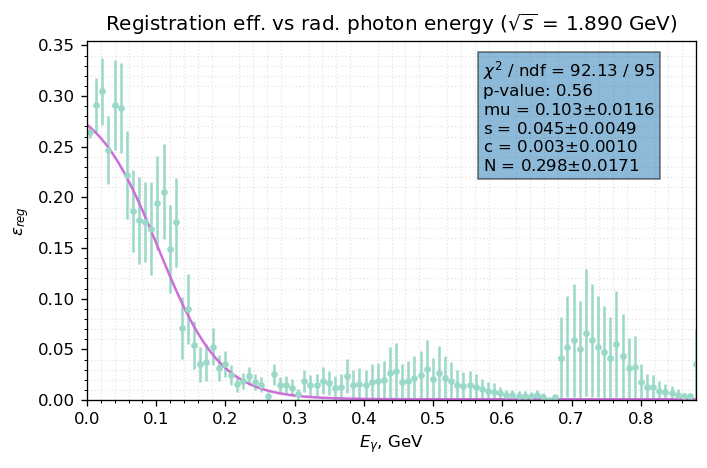

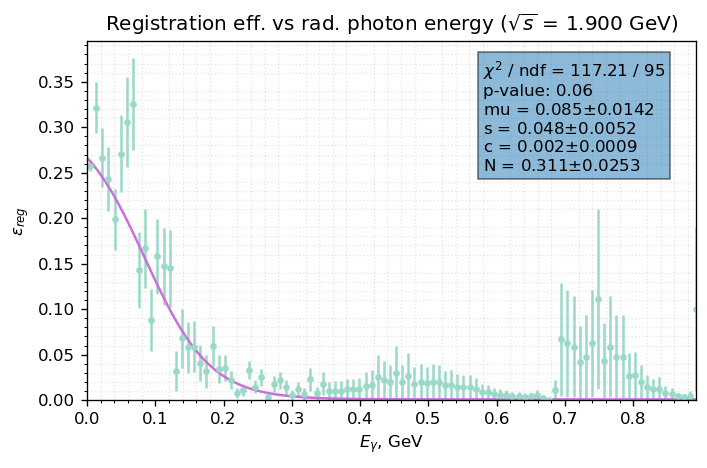

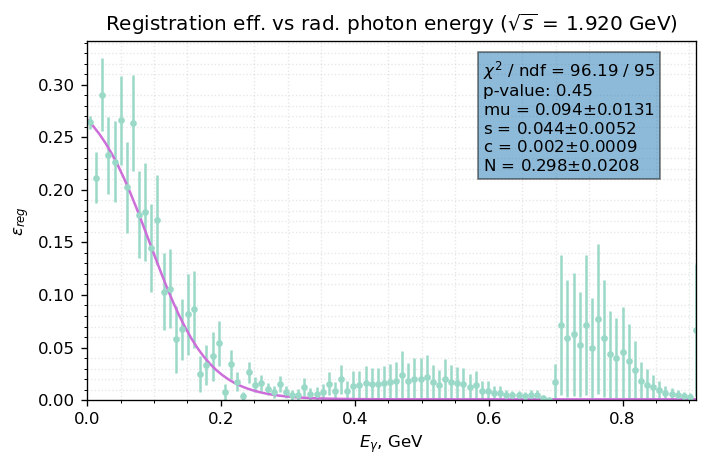

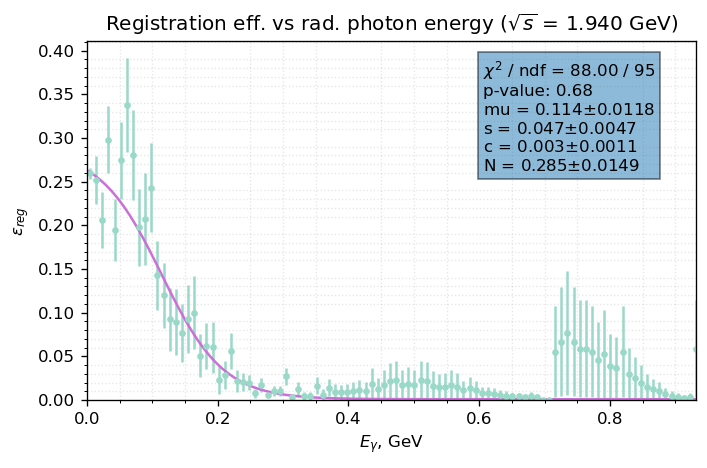

In [85]:
for i in range(len(reg)):
    reg.fit(i, data_color='#9AD9C8', fit_color='#CC6FD9')
    plt.grid(alpha=0.3)
    if not(os.path.isdir(f'images/regeff{SEASON}')):
        os.mkdir(f'images/regeff{SEASON}')
    plt.savefig(f'images/regeff{SEASON}/{i}.png')
    plt.show()

In [86]:
# reg.fit_results.to_csv(f'../data/{SEASON}/results/reg_eff.csv')

In [87]:
reg.fit_results.head()

,mu,s,c,N,mu_err,s_err,c_err,N_err,eff0,eff0_err
935.0,0.094162,0.043344,0.002688,0.287335,0.011317,0.004835,0.001025,0.017744,0.258727,0.016760
945.0,0.102944,0.044885,0.002610,0.298265,0.011596,0.004929,0.000976,0.017130,0.271703,0.016066
950.0,0.084567,0.047864,0.002326,0.311170,0.014185,0.005242,0.000903,0.025347,0.266481,0.025774
960.0,0.093665,0.043777,0.002264,0.297720,0.013059,0.005179,0.000867,0.020768,0.267042,0.020097
970.0,0.114183,0.047174,0.003357,0.285295,0.011761,0.004724,0.001091,0.014937,0.262966,0.014237


In [88]:
import re

In [89]:
dfs_reg = {re.findall(r'data/(.*)/results', i)[0] : 
           pd.read_csv(i, index_col=0) for i in glob('../data/*/results/reg_eff.csv')}

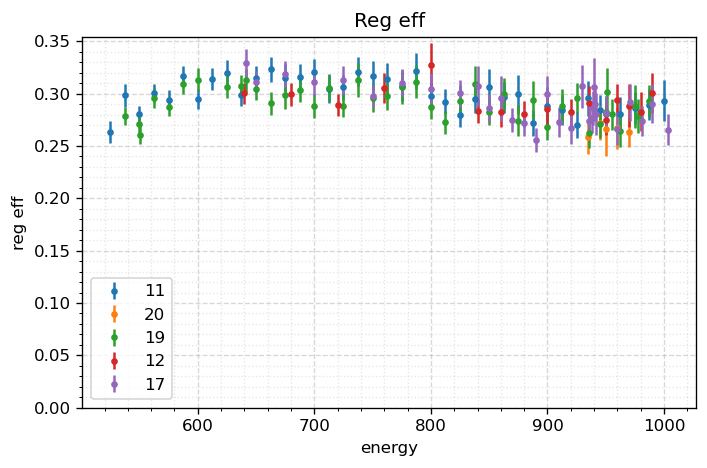

In [90]:
for key in dfs_reg:
    plt.errorbar(dfs_reg[key].index, dfs_reg[key].eff0, 
                 yerr=dfs_reg[key].eff0_err, fmt='.', label=key)
# plt.errorbar(dd.index, dd.eff0, yerr=dd.eff0_err, fmt='.')
pys.my_style('Reg eff', xtitle='energy', ytitle='reg eff', legend=True,
            ylim=(0, None))

## Аппроксимация сечения

In [2]:
from pylib.csapprox import MDVM

In [6]:
df_koz = pd.read_csv('images/kozyrev.txt').rename({'E': 'emeas', 'cs': 'cs_born',
                                                  'cs_err': 'cs_born_err'}, axis=1)
df_koz['emeas'] /= 2

In [7]:
dfs = [pd.read_csv('images/res11_new.csv', index_col=0),
       pd.read_csv('images/res12_new.csv', index_col=0),
       pd.read_csv('images/res19_new.csv', index_col=0),
       pd.read_csv('images/res20_new.csv', index_col=0),
      ]

In [8]:
for df in dfs:
    if 'n_sig_exp' not in df.columns:
        df['n_sig'] = df['n_exp']*df['f_exp']
        df['n_sig_err'] = df['n_sig']*np.sqrt( (df['n_exp_err']/df['n_exp'])**2 + (df['f_exp_err']/df['f_exp'])**2 )
    else:
        df['n_sig'] = df['n_sig_exp']
        df['n_sig_err'] = df['n_sig_exp_err']
    df['cs_born_err'] = df['cs_born']*np.sqrt( (df['n_sig_err']/df['n_sig'])**2 + (df['eff_reg_err']/df['eff_reg'])**2 +\
                                             (df['eff_trig_err']/df['eff_trig'])**2)

In [9]:
dfs = pd.concat([df_koz, *dfs])[['emeas', 'cs_born', 'cs_born_err']]
dfs.emeas *=2e-3

In [10]:
mdvm = MDVM()

In [11]:
params = [0.9639, 1.0919, -0.0062, -0.0279, 1.0509, 
          -0.0674, 1740.0, 250.0, 1670.0, 315.0, 1680.0, 
          150.0, 2150.0, 315.0, 1470.0, 400.0, 1425.0, 
          225.0, 2239.0, 139.0, 1.3856, 0.0064, -0.2363, 0.01]

In [12]:
m = iminuit.Minuit(iminuit.cost.LeastSquares(dfs.emeas, 
        dfs.cs_born, dfs.cs_born_err, lambda x, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23: 
            mdvm.Cross_Section_Neutral(x, [a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23])), *params)

In [15]:
m.simplex()#.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 341.3                      │             Nfcn = 11217             │
│ EDM = 0.114 (Goal: 0.1)          │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │ 911.6e-3  │  0.6e-3   │            │            │         │         │       │
│ 1 │ a1   │  1.1265   │  0.0015   │            │            │         │         │       │
│ 2 │ a2   │  0.0029   │  0.0012   │            │            │         │         │       │
│ 3 │ a3   │ -0.52e-3  │  0.10e-3  │            │            │         │         │       │
│ 4 │ a4   │  1.12305  │  0.00020  │            │            │         │         │       │
│ 5 │ a5   │ -83.4e-3  │  0.7e-3   │            │            │         │         │       │
│ 6 │ a6   │ 1.8035e3  │ 0.0005e3  │            │            │         │         │       │
│ 7 │ a7   │    2.7    │    1.5    │            │            │         │         │       │
│ 8 │ a8   │ 1.6187e3  │ 0.0016e3  │            │            │         │         │       │
│ 9 │ a9   │    523    │     8     │            │            │         │         │       │
│ 10│ a10  │ 1.6713e3  │ 0.0010e3  │            │            │         │         │       │
│ 11│ a11  │   139.4   │    2.8    │            │            │         │         │       │
│ 12│ a12  │ 1.5574e3  │ 0.0013e3  │            │            │         │         │       │
│ 13│ a13  │    279    │     4     │            │            │         │         │       │
│ 14│ a14  │  1.82e3   │  0.07e3   │            │            │         │         │       │
│ 15│ a15  │  0.51e3   │  0.10e3   │            │            │         │         │       │
│ 16│ a16  │ 1.4792e3  │ 0.0017e3  │            │            │         │         │       │
│ 17│ a17  │    9.9    │    2.6    │            │            │         │         │       │
│ 18│ a18  │  2.021e3  │  0.009e3  │            │            │         │         │       │
│ 19│ a19  │   -296    │    11     │            │            │         │         │       │
│ 20│ a20  │  1.4482   │  0.0023   │            │            │         │         │       │
│ 21│ a21  │  3.6e-3   │  0.6e-3   │            │            │         │         │       │
│ 22│ a22  │  -0.3583  │  0.0010   │            │            │         │         │       │
│ 23│ a23  │  -0.0477  │  0.0015   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [16]:
xx = np.linspace(dfs.emeas.min(), dfs.emeas.max(), 200)
yy = mdvm.Cross_Section_Neutral(xx, m.values)

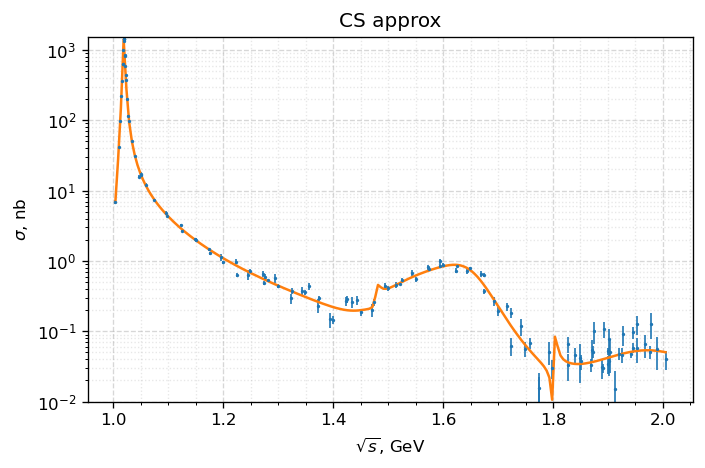

In [17]:
plt.errorbar(dfs.emeas, dfs.cs_born, yerr=dfs.cs_born_err, fmt='.', label=f'Measured cs', alpha=1, markersize=2, lw=1)
plt.plot(xx, yy)
pys.my_style(title='CS approx', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb',
            ylim=(1e-2, None))
plt.yscale('log')

In [18]:
df_fit = pd.DataFrame({'emeas': xx, 'cs_born': yy})

## Радпоправки

In [1]:
from pylib.radcors import RadCor

In [19]:
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

In [ ]:
df_c = 

In [ ]:
df_cutted = df_rad.dropna().reset_index().set_index(['season', 'index']).copy()
for index, j in df_cutted.iterrows():
    rad, rad_err = r.F_Radcor(index[1], j[['mu', 's', 'c', 'N']])/RegEff.sigFunc(0, *j[['mu', 's', 'c', 'N']])
    df_cutted.at[index, 'rad_new'], df_cutted.at[index, 'rad_new_err'] = rad, rad_err

In [123]:
df_fit.head()

,emeas,cs_born
0,1.004066,6.855869
1,1.009094,28.046279
2,1.014122,148.726144
3,1.019150,1409.010518
4,1.024178,277.801752


In [147]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [136]:
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

In [139]:
df_regeff = pd.read_csv('images/reg_eff_19.csv', index_col=0)

In [163]:
ens, rads = [], []
for i, j in df_regeff.iterrows():
    rad, rad_err = r.F_Radcor(i, j[:4])/RegEff.sigFunc(0, *j[:4])
    ens.append(i)
    rads.append(rad)

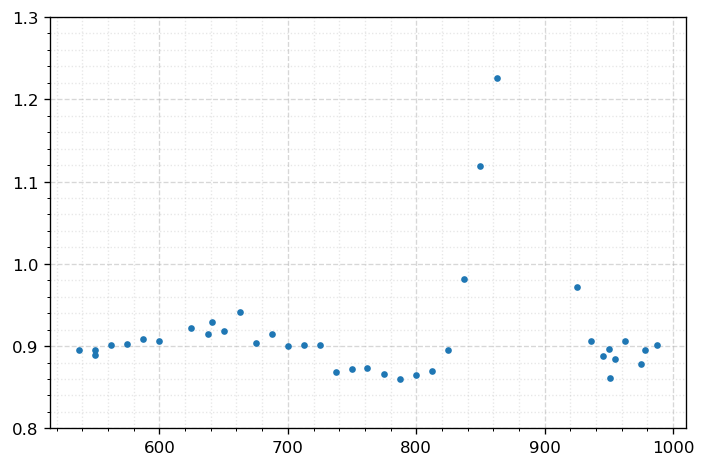

In [169]:
plt.errorbar(ens, rads, fmt='.')
pys.my_style(ylim=(0.8, 1.3))

In [55]:
t = uproot.open('/store17/petrov/data/kskl20/tr_ph/multi/tr_ph_kskl_950_79625.root')['tr_ph']

In [59]:
t.arrays?

Signature:
t.arrays(
    expressions=None,
    cut=None,
    filter_name=<function no_filter at 0x7fcc3adadb90>,
    filter_typename=<function no_filter at 0x7fcc3adadb90>,
    filter_branch=<function no_filter at 0x7fcc3adadb90>,
    aliases=None,
    language=<uproot.language.python.PythonLanguage object at 0x7fcc3ad9f290>,
    entry_start=None,
    entry_stop=None,
    decompression_executor=None,
    interpretation_executor=None,
    array_cache='inherit',
    library='ak',
    how=None,
)
Docstring:
Args:
    expressions (None, str, or list of str): Names of ``TBranches`` or
        aliases to convert to arrays or mathematical expressions of them.
        Uses the ``language`` to evaluate. If None, all ``TBranches``
        selected by the filters are included.
    cut (None or str): If not None, this expression filters all of the
        ``expressions``.
    filter_name (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above):

In [63]:
arrt, arrs = t.arrays(expressions=['trho', 'simtype'], library='pd')

In [74]:
arrt

trho
entry subentry          
0     0         0.003162
      1        -0.004339
1     0         0.010883
2     0        -0.029699
      1         0.024816
...                  ...
99998 0        -0.003227
      1         0.050302
      2        -0.038940
99999 0         0.006211
      1        -0.073825

[243870 rows x 1 columns]

In [86]:
arrt = arrt.reset_index().drop('subentry', axis=1).set_index('entry')

In [89]:
arrtkskl = arrt.loc[arrt.index & ((arrs == 130) | (arrs == 310)).groupby('entry').agg('max').query('simtype').index]
arrtnotkskl = arrt.loc[arrt.index & ((arrs == 130) | (arrs == 310)).groupby('entry').agg('max').query('simtype==False').index]

MultiIndex([], names=['entry', 'subentry'])

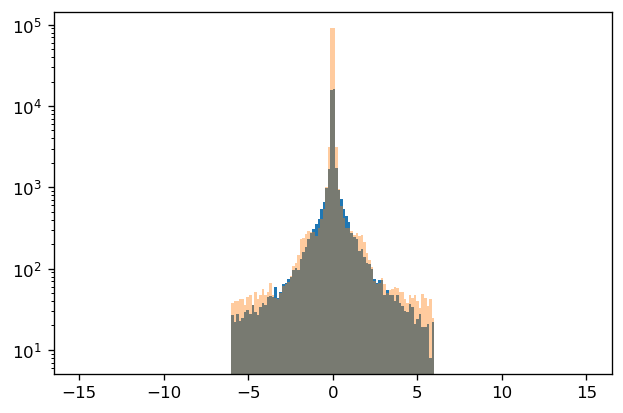

In [92]:
plt.hist( arrtkskl.trho, bins=200, range=(-15, 15) );
plt.hist( arrtnotkskl.trho, bins=200, range=(-15, 15), alpha=0.4 );
plt.yscale('log')